# Principal Component Analysis - PCA

- Check vector representations of word using pre-loaded word embeddings
- Compare word embeddings by using a similarity measure (the cosine similarity) and eulidean distance.
- Use PCA to reduce the dimensionality of the Word2Vec word embeddings and plot them in two dimensions for visualization.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
# load word embedding model
word_embeddings = pickle.load(open('./word_embeddings_subset.p', 'rb'))
print('Dimension of word \'Spain\' in the word embedding model: ', word_embeddings['Spain'].shape)


Dimension of word 'Spain' in the word embedding model:  (300,)


In [3]:
# cosine similarity function definition
def cosine_similarity(word1, word2):
    """
    Params:
    ----------
    word1: numpy array
        representing word vector
    word2: numpy array
        representing word vector

    Returns:
    ----------
    score: numpy float
        cosine similarity score of word1 and word2

    """
    
    return np.dot(word1, word2) / (np.linalg.norm(word1) * np.linalg.norm(word2))

In [4]:
# Check out cosine similarity b/w king and queen
king = word_embeddings['king']
queen = word_embeddings['queen']

cosine_similarity(king, queen)

0.6510957

In [5]:
# euclidean distance function definition
def euclidean(word1, word2):
    """
    Params:
    ----------
    word1: numpy array
        representing word vector
    word2: numpy array
        representing word vector

    Returns:
    ----------
    euclid_distance: numpy float
        euclidean distance between word vectors word1 and word2

    """
    
    return np.linalg.norm(word1-word2)

In [6]:
# Check out eulidean distance b/w king and queen
king = word_embeddings['king']
queen = word_embeddings['queen']

euclidean(king, queen)

2.4796925

In [7]:
# function to find the country that has its capital as 'city2' by learning latent relationship b/w a pair of given (city, country) data
def get_country(city1, country1, city2, word_embeddings):
    """
    Params:
    ---------
    city1: string
        capital city of country1
    country1 : string
        country which has the capital as city1
    city2: string
        capital city of the country to be found
    word_embeddings: dict
        dictionary of words, having values as their vector representation
    
    Returns:
    ----------
    country2: tuple of (country, cosine similarity score)
        country which has capital city as city2
    """

    # get vector representions of cities and countries
    city1_vec = word_embeddings[city1]
    country1_vec = word_embeddings[country1]
    city2_vec = word_embeddings[city2]
    
    # derive latent relationship b/w city1 and country1 and establish same relationship b/w city2 and country2
    country2_vec = country1_vec - city1_vec + city2_vec


    # find the word having the highest similarity score with city2
    country2 = ''
    max_cosine_similarity_score = 0
    for word in word_embeddings:
        if word not in set((city1, country1, city2)):
            cosine_similarity_score = cosine_similarity(word_embeddings[word], country2_vec)
            if cosine_similarity_score > max_cosine_similarity_score:
                max_cosine_similarity_score = cosine_similarity_score
                country2 = (word, max_cosine_similarity_score)
    return country2



In [8]:
# given the relationship b/w Athens and Greece, find the country whose capital is Cairo
get_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626821)

In [9]:
# load a dataset to test accuracy of embedding model
data = pd.read_csv('capitals.txt', delimiter=' ')
data.columns = ['city1', 'country1', 'city2', 'country2']

# print first five elements in the DataFrame
data.head(5)

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


In [10]:
def get_accuracy(data, word_embeddings):
    """
    Params:
    ----------
    data: pandas dataframe
        the dataset to containing (city1, country1, city2, country2) as records
    word_embeddings: dict
        a dictionary where keys are the words and values represent the vector represention of the word
    
    Returns:
    ----------
    accuracy: numpy float
        accuracy score of the word embedding model
    """

    accuracy = np.mean(data.apply(lambda row: get_country(row['city1'], row['country1'], row['city2'], word_embeddings)[0] == row['country2'], axis=1))

    return accuracy

In [11]:
# find accuracy of the word embedding model
accuracy = get_accuracy(data, word_embeddings)
accuracy

0.9192082407594425

In [12]:
# computes the pca and returns the data matrix after dimensionality reduction
def compute_pca(X, n_components=2):
    """
    Params:
    ----------
    X: numpy array
        m x n dimensional data matrix containing m word samples / observations and n dimensional vector representation of the words
    n_components: int
        the dimension to reduce the input data matrix X using PCA
    
    Returns:
    ----------
    X_transformed: numpy array
        m x n_components data matrix after dimensionality reduction using PCA
    """

    # mean center data
    X = X - np.mean(X, axis=0)         # (m,n) array

    # compute covariance matrix
    X_cov = np.cov(X, rowvar=False)    # (n,n) array

    # compute eigen vectors and eigen values of covariance matrix
    eigen_values, eigen_vectors = np.linalg.eigh(X_cov)       # (n,) and (n,n) arrays  

    # get the indices of eigen_values sorted by descending order of its values
    sorted_indices = np.argsort(eigen_values)[::-1]

    # get the eigen vectors / Principal components as per n_components
    eigen_vectors = eigen_vectors[:, sorted_indices][:, :n_components]     # (n,n_components) array

    # transform the original (m x n) dimensional data matrix to (m x n_component) dimensional data by projection
    X_transformed = np.dot(X, eigen_vectors)

    return X_transformed



In [13]:
# Testing compute_pca() function
np.random.seed(1)
X = np.random.rand(3, 10)
X_reduced = compute_pca(X, n_components=2)
print("Your original matrix was " + str(X.shape) + " and it became:")
print(X_reduced)

Your original matrix was (3, 10) and it became:
[[ 0.43437323  0.49820384]
 [ 0.42077249 -0.50351448]
 [-0.85514571  0.00531064]]


In [14]:
# function which creates a data matrix from word embeddings and words
def get_vectors(word_embeddings, words):
    """
    Params:
    ----------
    word_embeddings: dict
        dictionary of words and their vector representations
    words: list
        list of str formatted words   

    Returns:
    ----------
    X: numpy array
        a matrix where the rows are the embeddings corresponding to the rows on the word list
    """
    # find the word embedding dimension from the given embedding dictionary
    word_embedding_dim = len(word_embeddings[list(word_embeddings.keys())[0]])

    # Initialize X 
    X = np.zeros((1, word_embedding_dim))

    # Add rows corresponding to the vector represention of each word
    for word in words:
        X = np.vstack((X, word_embeddings[word]))
    X = X[1:, ]

    return X

In [15]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
X = get_vectors(word_embeddings, words)

print('You have 11 words each of 300 dimensions thus X.shape is:', X.shape)

You have 11 words each of 300 dimensions thus X.shape is: (11, 300)


In [16]:
# function to visualize high dimensional data in 2D after dimensionality reduction using PCA
def pca_plot(words, n_components):
    """
    Params: 
    ----------
    words: list
        a list of word to plot 
    n_components: int
        the dimension to reduce the input words having n dimensional embeddings using PCA
    
    Returns:
    ----------
    A matplotlib plot of X data reduced to n_components dimension          
    """
    # create a data matrix where the rows are the word embeddings corresponding to each word in the words list
    X = get_vectors(word_embeddings, words)

    # get PCA reduced data matrix
    X_transformed = compute_pca(X, n_components=n_components)

    # plot in 2D
    x = X_transformed[:, 0]
    y = X_transformed[:, 1]

    plt.figure(figsize=(10,7))
    plt.scatter(x, y)

    # annotate points with words
    for idx in range(len(words)):
        plt.annotate(words[idx], (x[idx] + 0.05, y[idx] + 0.05), fontsize=15)

    # generate plot
    plt.show()

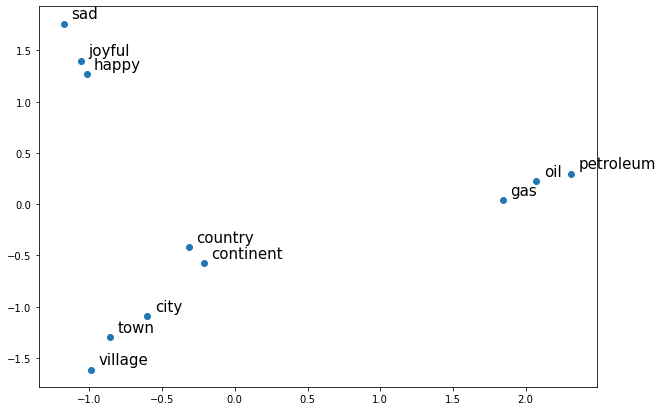

In [17]:
# plot 
pca_plot(words, n_components=2)